In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/autoam-car-price-prediction/sample_submission.csv
/kaggle/input/autoam-car-price-prediction/train.csv
/kaggle/input/autoam-car-price-prediction/test.csv


In [2]:
#upload the train.csv file as train_data
train_data = pd.read_csv('/kaggle/input/autoam-car-price-prediction/train.csv')
X_test = pd.read_csv('/kaggle/input/autoam-car-price-prediction/test.csv')

In [3]:
train_data.head()

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700
3,mercedes-benz,2002,petrol,137000 miles,left,golden,sedan,excellent,3.2,12000
4,mercedes-benz,2017,petrol,130000 km,left,black,sedan,good,2.0,26000


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1642 non-null   object 
 1   year          1642 non-null   int64  
 2   motor_type    1642 non-null   object 
 3   running       1642 non-null   object 
 4   wheel         1642 non-null   object 
 5   color         1642 non-null   object 
 6   type          1642 non-null   object 
 7   status        1642 non-null   object 
 8   motor_volume  1642 non-null   float64
 9   price         1642 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 128.4+ KB


In [5]:
train_data.duplicated().sum()

9

In [6]:
train_data.drop_duplicates(inplace=True)

In [7]:
for column in train_data.columns:
    if train_data[column].dtype=='object':
        print(train_data[column].value_counts())
        print('------------------------------------')

model
mercedes-benz    401
nissan           349
hyundai          347
kia              283
toyota           253
Name: count, dtype: int64
------------------------------------
motor_type
petrol            1412
gas                165
petrol and gas      53
diesel               2
hybrid               1
Name: count, dtype: int64
------------------------------------
running
300000  km      19
70000  miles    18
120000  km      16
65000  miles    15
60000  miles    15
                ..
201000  km       1
8800  km         1
101  miles       1
96122  km        1
68900  miles     1
Name: count, Length: 643, dtype: int64
------------------------------------
wheel
left    1633
Name: count, dtype: int64
------------------------------------
color
black      537
white      406
silver     220
gray       188
blue       141
red         47
other       30
cherry      20
green       10
brown       10
golden       6
orange       5
beige        5
clove        3
purple       2
skyblue      2
pink         1
N

In [8]:
train_data['year'] = train_data['year'].astype(object)
X_test['year'] = X_test['year'].astype(object)
ids = X_test['Id']
X_test = X_test.drop('Id', axis=1)
train_data.drop('wheel', axis=1, inplace=True)
X_test.drop('wheel', axis=1, inplace=True)

In [9]:
#split the train_data to train data and labels
X_train_full = train_data.drop('price', axis=1)
y_train_full = train_data['price']

In [10]:
def convert_miles_to_kilometers(distance_str):
    if 'miles' in distance_str.lower():
        miles = float(distance_str.split()[0])
        kilometers = miles * 1.60934
        return kilometers
    else:
        return float(distance_str.split()[0])

In [11]:
X_train_full['running'] = X_train_full['running'].apply(convert_miles_to_kilometers)

In [12]:
X_test['running'] = X_test['running'].apply(convert_miles_to_kilometers)

In [13]:
X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1633 entries, 0 to 1641
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1633 non-null   object 
 1   year          1633 non-null   object 
 2   motor_type    1633 non-null   object 
 3   running       1633 non-null   float64
 4   color         1633 non-null   object 
 5   type          1633 non-null   object 
 6   status        1633 non-null   object 
 7   motor_volume  1633 non-null   float64
dtypes: float64(2), object(6)
memory usage: 114.8+ KB


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full,
                                                      test_size=.1, random_state=42)

In [15]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
cat_cols = ['model', 'year', 'motor_type', 'color', 'type', 'status']

for col in cat_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col].values)
    X_valid[col] = label_encoder.transform(X_valid[col])
    X_test[col] = label_encoder.transform(X_test[col])

In [16]:
X_train.head()

,model,year,motor_type,running,color,type,status,motor_volume
768,3,26,3,128747.20,14,6,1,2.0
261,1,27,3,43452.18,1,5,1,2.0
1409,1,28,3,53108.22,7,5,1,2.0
1313,0,26,3,65982.94,1,5,1,2.0
1423,0,29,3,41842.84,7,5,1,2.0


In [17]:
X_train = pd.get_dummies(X_train, columns=['status'])
X_valid = pd.get_dummies(X_valid, columns=['status'])
X_test = pd.get_dummies(X_test, columns=['status'])

In [18]:
X_train.replace({True:1, False:0}, inplace=True)
X_valid.replace({True:1, False:0}, inplace=True)
X_test.replace({True:1, False:0}, inplace=True)

In [19]:
columns = X_train.columns

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train.values)
X_valid = scaler.transform(X_valid.values)
X_test = scaler.transform(X_test.values)

In [21]:
X_train = pd.DataFrame(X_train, columns=columns)
X_valid = pd.DataFrame(X_valid, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

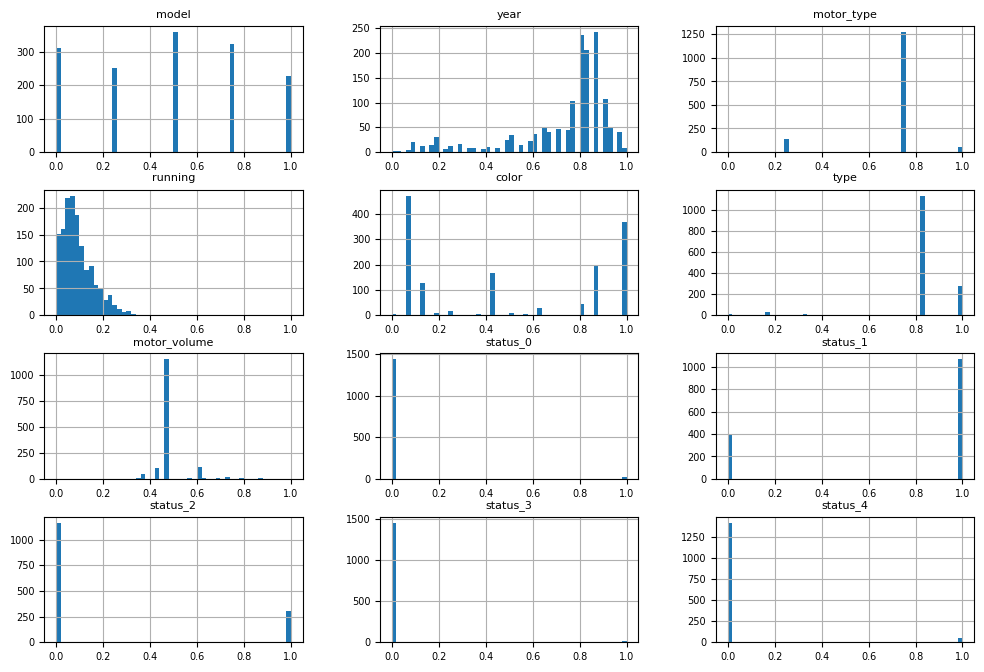

In [22]:
import matplotlib.pyplot as plt
plt.rc('font', size=8)
plt.rc('axes', labelsize=8, titlesize=8)
plt.rc('legend', fontsize=8)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)

X_train.hist(bins=50, figsize=(12, 8))
plt.show()

Text(99.72222222222221, 0.5, 'Features')

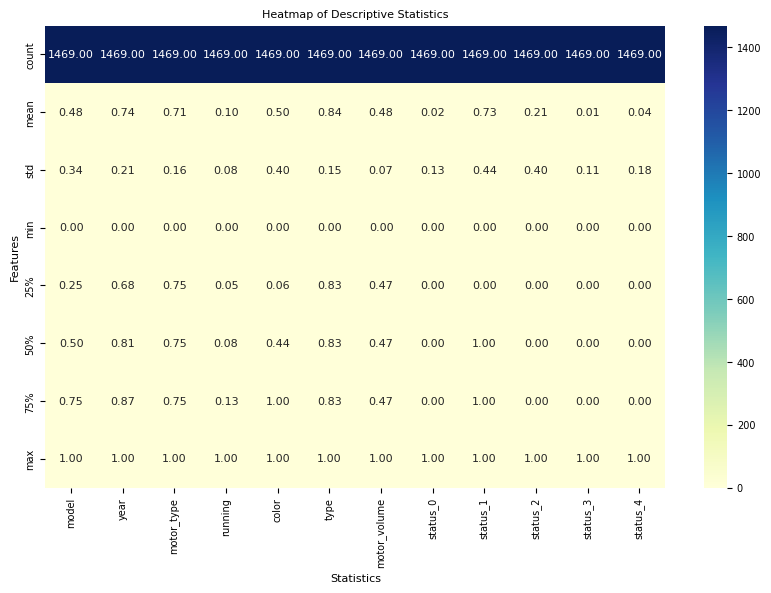

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

desc_stats = X_train.describe()

plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(desc_stats, annot=True, fmt=".2f", cmap='YlGnBu')

plt.title('Heatmap of Descriptive Statistics')
plt.xlabel('Statistics')
plt.ylabel('Features')

In [24]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

lin_reg = LinearRegression()
ridge = Ridge()
lasso = Lasso()
tree_reg = DecisionTreeRegressor()
grad_boost_reg = GradientBoostingRegressor()
XGB_reg = XGBRegressor()
catboost_reg = CatBoostRegressor(loss_function='MAE', silent = True)
h_grad_boost_reg = HistGradientBoostingRegressor()
svm_reg = SVR()


In [25]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

def display_scores(models, X_valid=X_valid, y_valid=y_valid):
    name, rmse, mae ,score ,rmse_scores= [],[],[],[],[]
    for model in models:
        name.append(type(model).__name__)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        rmse.append(np.sqrt(mean_squared_error(y_valid, y_pred)))
        mae.append(mean_absolute_error(y_valid, y_pred))
        scores = cross_val_score(model, X_valid, y_valid, scoring="neg_mean_squared_error", cv=10).mean()
        score.append(-scores.T.round(2))
        rmse_scores.append(np.sqrt(-scores.T.round(2)))
    result = pd.DataFrame({'MODEL':name, 'RMSE':rmse, 'MAE':mae, 'SCORES MEAN':score, 'SCORES RMSE':rmse_scores})
    return result.style.highlight_min(subset=['RMSE','MAE', 'SCORES MEAN', 'SCORES RMSE'], color='lightgreen').highlight_max(subset=['RMSE','MAE', 'SCORES MEAN', 'SCORES RMSE'], color='pink')
    

In [26]:
models = [lin_reg,ridge,lasso,tree_reg,XGB_reg,grad_boost_reg,catboost_reg,svm_reg]
display_scores(models)

,MODEL,RMSE,MAE,SCORES MEAN,SCORES RMSE
0,LinearRegression,5168.118715,3426.640244,31430193.630000,5606.263785
1,Ridge,5165.681192,3389.858480,29556699.940000,5436.607392
2,Lasso,5166.308166,3409.137903,31308042.660000,5595.359029
3,DecisionTreeRegressor,4070.044309,2473.713415,33265393.800000,5767.615955
4,XGBRegressor,3430.761610,2163.396376,16264468.240000,4032.923039
5,GradientBoostingRegressor,3199.418129,2021.851711,17292870.590000,4158.469741
6,CatBoostRegressor,3090.921506,1900.248123,16858700.670000,4105.934811
7,SVR,7601.591896,5553.516174,58428273.990000,7643.838956


In [27]:
from sklearn.model_selection import RandomizedSearchCV

model = CatBoostRegressor(loss_function='MAE', silent = True)
param_grid ={
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [ 3, 5, 7],
}
grid_search = RandomizedSearchCV(
    estimator = model ,
    param_distributions = param_grid,
    scoring = 'neg_mean_absolute_error',
    n_jobs = 4,
    verbose=True, 
    cv = 10,
     )
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f02dbc56830>,
                   n_jobs=4,
                   param_distributions={'depth': [4, 6, 8],
                                        'iterations': [50, 100, 200],
                                        'l2_leaf_reg': [3, 5, 7],
                                        'learning_rate': [0.01, 0.1]},
                   scoring='neg_mean_absolute_error', verbose=True)

In [28]:
grid_search.best_params_

{'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 100, 'depth': 6}

In [29]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

45.59211553009191 {'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 50, 'depth': 8}
62.82687718575792 {'learning_rate': 0.01, 'l2_leaf_reg': 7, 'iterations': 50, 'depth': 4}
61.5795465625721 {'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 50, 'depth': 8}
44.818157959872245 {'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 100, 'depth': 6}
48.205451433758604 {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 50, 'depth': 4}
50.924802339153935 {'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 6}
53.27146730814639 {'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 4}
53.21321515736641 {'learning_rate': 0.01, 'l2_leaf_reg': 7, 'iterations': 200, 'depth': 4}
62.84487099348157 {'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 50, 'depth': 4}
45.84705264705301 {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 50, 'depth': 8}


In [30]:
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)

In [31]:
result = pd.DataFrame(data={'Id':ids, 'price':y_pred})

In [32]:
result.head()

,Id,price
0,0,17608.906487
1,1,17014.716007
2,2,22628.110058
3,3,14744.895356
4,4,6709.210731


In [33]:
result.to_csv('submission.csv', index=False)